<a href="https://colab.research.google.com/github/wyctorfogos/DarkNet---Classifier-PyTorch-/blob/main/Darknet_19_classifier_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torch.optim import Adam, SGD, RMSprop
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

torch.manual_seed(17)

In [2]:
transformations = transforms.Compose([
#    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0., std=1.)
])

In [33]:
from torchvision.datasets.fakedata import transforms

#train= datasets.CIFAR10(root='data', download=True, train=True, transform=transformations)
#test= datasets.CIFAR10(root='data',download=True, train=False, transform=transformations)

train = datasets.VOCDetection(root= './data', year = '2012', image_set = 'train', download = True, transform = transformations)
test = datasets.VOCDetection(root= './data', year = '2012', image_set = 'val', download = True, transform = transformations)

batch=1

dataset_train = DataLoader(train, batch_size=batch, shuffle=True)
dataset_test = DataLoader(test, batch_size=batch, shuffle=False)

Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


Test dataset

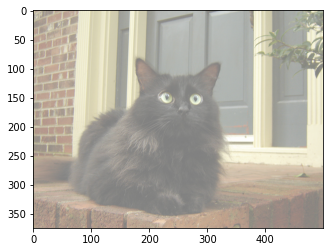

{'annotation': {'filename': ['2010_002573.jpg'], 'folder': ['VOC2012'], 'object': [{'name': ['cat'], 'bndbox': {'xmax': ['342'], 'xmin': ['63'], 'ymax': ['352'], 'ymin': ['79']}, 'difficult': ['0'], 'occluded': ['0'], 'pose': ['Frontal'], 'truncated': ['0']}], 'segmented': ['1'], 'size': {'depth': ['3'], 'height': ['375'], 'width': ['500']}, 'source': {'annotation': ['PASCAL VOC2010'], 'database': ['The VOC2010 Database'], 'image': ['flickr']}}}


In [34]:
import matplotlib.pyplot as plt
import numpy as np

data_iter = iter(dataset_train)
images, labels = data_iter.next()

def plot_images(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
plot_images(torchvision.utils.make_grid(images))
print(labels)

del images
del labels

In [7]:
##Darknet-19 model

class BlockConv1(nn.Module):
  def __init__(self, input_channels, output_channels, num_kernel=1, size_stride=1, *kwgars):
    super().__init__()
    self.conv1 = nn.Conv2d(input_channels,output_channels, kernel_size=num_kernel*3, stride=size_stride, padding=1)
    self.batch1 = nn.BatchNorm2d(output_channels)
    self.conv2 = nn.Conv2d(output_channels,input_channels, kernel_size=num_kernel, stride=(size_stride), padding=0)
    self.batch2 = nn.BatchNorm2d(input_channels)
    self.conv3 = nn.Conv2d(input_channels,output_channels, kernel_size=num_kernel*3, stride=size_stride, padding=1)
    self.batch3 = nn.BatchNorm2d(output_channels)
    self.max_pool=nn.MaxPool2d(kernel_size=2, stride=2)
    self.relu= nn.ReLU()

  def forward(self,x):
    X = self.relu(self.batch1(self.conv1(x)))
    X= self.relu(self.batch2(self.conv2(X)))
    X = self.relu(self.conv3(X))
    X = self.conv3(X)
    X = self.relu(self.batch3(self.conv3(x)))
    X = self.max_pool(X)
    return X

class DarkNetClassifier(nn.Module):
  def __init__(self, Block1Conv1, input_channels=3, num__kernels=1,  num_stride=1, num_classes=20):
    self.num_classes=num_classes

    ##Darknet part
    super(DarkNetClassifier, self).__init__()
    self.conv1 = nn.Conv2d(input_channels,32, kernel_size = 3*num__kernels, stride = num_stride*3, padding=1, bias=False)
    self.batch1= nn.BatchNorm2d(32)
    self.max_pool1=nn.MaxPool2d(kernel_size = 2, stride = 2)
    self.conv2 = nn.Conv2d(32,64, kernel_size = (3*num__kernels), stride = num_stride*3, padding=1, bias=False)
    self.batch2= nn.BatchNorm2d(64)
    self.max_pool2=nn.MaxPool2d(kernel_size = 2, stride = 2)

    ##self.block1 = BlockConv1(input_channels=64,output_channels=128,num_kernel=(num__kernels), size_stride=num_stride)
    ##self.block2 = BlockConv1(input_channels=128,output_channels=256,num_kernel=(num__kernels), size_stride=num_stride)
    self.conv1_block1 = nn.Conv2d(64, 128, kernel_size=num__kernels*3, stride=num_stride, padding=1)
    self.batch1_block1 = nn.BatchNorm2d(128)
    self.conv2_block1 = nn.Conv2d(128,64, kernel_size=num__kernels, stride=(num_stride), padding=0)
    self.batch2_block1 = nn.BatchNorm2d(64)
    self.conv3_block1 = nn.Conv2d(64,128, kernel_size=num__kernels*3, stride=num_stride, padding=1)
    self.batch3_block1 = nn.BatchNorm2d(128)
    self.max_pool1_block1=nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv1_block2 = nn.Conv2d(128, 256, kernel_size=num__kernels*3, stride=num_stride, padding=1)
    self.batch1_block2 = nn.BatchNorm2d(256)
    self.conv2_block2 = nn.Conv2d(256,128, kernel_size=num__kernels, stride=(num_stride), padding=0)
    self.batch2_block2 = nn.BatchNorm2d(128)
    self.conv3_block2 = nn.Conv2d(128,256, kernel_size=num__kernels*3, stride=num_stride, padding=1)
    self.batch3_block2 = nn.BatchNorm2d(256)
    self.max_pool1_block2=nn.MaxPool2d(kernel_size=2, stride=2)
  
    
    self.conv3 = nn.Conv2d(256,512, kernel_size = (3*num__kernels), stride = num_stride, padding=1, bias=False)
    self.batch3= nn.BatchNorm2d(512)
    self.conv4 = nn.Conv2d(512,256, kernel_size = (num__kernels), stride = (num_stride), padding=0, bias=False)
    self.batch4= nn.BatchNorm2d(256)
    self.conv5 = nn.Conv2d(256,512, kernel_size = (3*num__kernels), stride = num_stride, padding=1, bias=False)
    self.batch5= nn.BatchNorm2d(512)
    self.conv6 = nn.Conv2d(512,256, kernel_size = (num__kernels), stride = (num_stride), padding=1, bias=False)
    self.batch6= nn.BatchNorm2d(256)
    self.conv7 = nn.Conv2d(256,512, kernel_size = (3*num__kernels), stride = num_stride, padding=1, bias=False)
    self.batch7= nn.BatchNorm2d(512)
    self.max_pool3=nn.MaxPool2d(kernel_size = 2, stride = 2)

    self.conv8 = nn.Conv2d(512, 1024, kernel_size = (3*num__kernels), stride = num_stride, padding=1, bias=False)
    self.batch8= nn.BatchNorm2d(1024)
    self.conv9 = nn.Conv2d(1024, 512, kernel_size = (num__kernels), stride = num_stride, padding=0, bias=False)
    self.batch9= nn.BatchNorm2d(512)
    self.conv10 = nn.Conv2d(512, 1024, kernel_size = (3*num__kernels), stride = num_stride, padding=1, bias=False)
    self.batch10= nn.BatchNorm2d(1024)
    self.conv11 = nn.Conv2d(1024, 512, kernel_size = (num__kernels), stride = (num_stride), padding=1, bias=False)
    self.batch11= nn.BatchNorm2d(512)
    self.conv12 = nn.Conv2d(512, 1024, kernel_size = (3*num__kernels), stride = num_stride, padding=1, bias=False)
    self.batch12 = nn.BatchNorm2d(1024)

    self.conv_last_layer=nn.Conv2d(1024,num_classes,kernel_size=(1,1), stride = (1,1), padding=1, bias=False)

    self.flatten= nn.Flatten()
    self.soft=nn.Softmax(dim=1)

    self.relu= nn.ReLU(0.1)

    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, num_classes)

  def forward(self,x):
    #model= self.soft(self.fc(self.avg(self.conv_last_layer(self.conv12(self.conv11(self.conv10(self.conv9(self.conv8(self.max_pool3(self.conv7(self.conv6(self.conv5(self.conv4(self.conv3(self.block2(self.block1(self.max_pool2(self.conv2(self.max_pool1(self.conv1(x)))))))))))))))))))))
    X = self.relu(self.batch1(self.conv1(x)))
    X = self.max_pool1(X)
    X = self.relu(self.batch2(self.conv2(X)))
    X = self.max_pool2(X)

    X = self.relu(self.batch1_block1(self.conv1_block1(X)))
    X = self.relu(self.batch2_block1(self.conv2_block1(X)))
    X = self.relu(self.batch3_block1(self.conv3_block1(X)))
    x = self.max_pool1_block1(X)
    
    X = self.relu(self.batch1_block2(self.conv1_block2(X)))
    X = self.relu(self.batch2_block2(self.conv2_block2(X)))
    X = self.relu(self.batch3_block2(self.conv3_block2(X)))
    X = self.max_pool1_block2(X)


    ##X = self.block1(X)
    ##X = self.block2(X)

    X = self.relu(self.batch7(self.conv7(self.relu(self.batch6(self.conv6(self.relu(self.batch5(self.conv5(self.relu(self.batch4(self.conv4(self.relu(self.batch3(self.conv3(X)))))))))))))))
    X = self.max_pool3(X)
    X = self.conv_last_layer(self.relu(self.batch12(self.conv12(self.relu(self.batch11(self.conv11(self.relu(self.batch10(self.conv10(self.relu(self.batch9(self.conv9(self.relu(self.batch8(self.conv8(X))))))))))))))))
    
    ##Classifier part
    N = X.data.size(0)
    C = X.data.size(1)
    H = X.data.size(2)
    W = X.data.size(3)

    #print(N,C,H,W)

    X = nn.AdaptiveAvgPool2d((H, W))(X)
    X = X.view(-1, (N*C*H*W))
 ##   X = self.soft(X)
    X = nn.Linear((N*C*H*W), self.num_classes)(X)
 #   x = X.view(X.size(0), -1)
 #   print(X.size(0))
 #   X = nn.Linear((N*C*H*W), self.num_classes)(X)
 #   X = self.fc2(X)
 #   model =self.fc3(X)
    #X = nn.Linear((N*C*H*W), self.num_classes)(X)

    
    return X



In [8]:

def test():
  model=DarkNetClassifier(BlockConv1, input_channels=3, num__kernels=1,  num_stride=1, num_classes=10)
  X=torch.rand(1, 3, 224, 224)
#  X.permute(0, 3, 1, 2)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
  Y = model(X).to(device)
#  Y = model.to(device)
  print(Y)
  #model.to(device)
  return model

In [9]:
model=test()
del model

tensor([[-0.1080, -0.1164,  0.0167, -0.0294, -0.0569, -0.0189,  0.1167, -0.1919,
          0.0037,  0.2086]], grad_fn=<AddmmBackward0>)


In [10]:
class ConvClassifier(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.max_pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, num_classes)

    ##activation function
    self.relu= nn.ReLU()

  def forward(self,x):
    X = self.relu(self.conv1(x))
    X= self.max_pool(X)
    X = self.relu(self.conv2(X))
    X= self.max_pool(X)
    X = X.view(-1 ,16*5*5)
    X= self.fc1(X)
    X = self.fc2(X)
    model =self.fc3(X)
    
    return model

def test_ConvClassifier():
  model=ConvClassifier(num_classes=10)
  X=torch.rand(1,3,32,32)
  #X.permute(0, 3, 1, 2)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
  Y = model(X).to(device)
  print(torch.argmax(Y))
  #model.to(device)
  return model

In [11]:
model=test_ConvClassifier()

del model

tensor(8)


In [12]:
class_names={'person':0, 'bird': 1, 'cat':2, 'cow':3, 'dog':4, 'horse':5, 'sheep':6, 'aeroplane':7, 'bicycle':8, 'boat':9, 'bus':10, 'car':11, 'motorbike':12, 'train':13, 'bottle':14, 'chair':15, 'dining table':16, 'potted plant':17, 'sofa':18, 'tv/monitor':19}

In [13]:
number=class_names.get('bicycle')
print(number)

8


In [14]:
def crop_images(imgs, x_min, y_min, x_max, y_max):
  image=transforms.ToPILImage()(imgs)
  plt.subplot(2,2,1)
  plt.imshow(image, interpolation="bicubic")
  plt.subplot(2,2,2)
  
  cropped_image=transforms.ToPILImage()(imgs)
  width = abs(int(x_min)-int(x_max))
  height = abs(int(y_min)-int(y_max))

  # Select area to crop
  area = (int(x_min), int(y_min), int(x_max), int(y_max))
    
  cropped_image=cropped_image.crop(area)
  plt.imshow(cropped_image)
  plt.show()

In [15]:
def select_info(annotations):
  obj_name=annotations["annotation"]['object'][-1]['name']
  obj_coord=annotations["annotation"]['object'][-1]['bndbox']
  x_min, y_min, x_max, y_max = obj_coord['xmin'], obj_coord['ymin'], obj_coord['xmax'], obj_coord['ymax']
  return x_min, y_min, x_max, y_max, obj_name, obj_coord 

In [16]:
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

epochs=25

model= model=DarkNetClassifier(BlockConv1, input_channels=3, num__kernels=1,  num_stride=1, num_classes=10)
#test_ConvClassifier()
model.to(device)

loss_functionn= torch.nn.CrossEntropyLoss().to(device)
opt=Adam(model.parameters(), lr=1e-4)




In [17]:
def create_array(Y_pred):
  y_pred=[]
  max_item=int(torch.argmax(Y_pred))
  for id in range(Y_pred.shape[-1]):
    if id==max_item:
      y_pred.append(1)
    else:
      y_pred.append(0)
  return torch.tensor(y_pred)

In [18]:
aux=create_array(Y_pred)
print(aux)

NameError: ignored

Batch: 0
['sheep']
{'xmax': ['418'], 'xmin': ['102'], 'ymax': ['395'], 'ymin': ['27']}
102 27 418 395


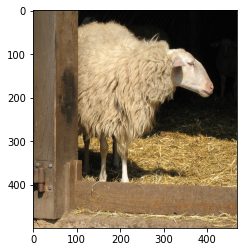

tensor([[-0.0649, -0.0154,  0.2118,  0.1719,  0.0295,  0.1876, -0.1101, -0.0374,
          0.2998,  0.1586, -0.1782,  0.0075, -0.1171,  0.0628,  0.0640, -0.0606,
         -0.0871,  0.0742,  0.1536, -0.0849]], grad_fn=<AddmmBackward0>) tensor([6])
tensor(3.1472, grad_fn=<NllLossBackward0>)
Batch: 1
['bus']
{'xmax': ['116'], 'xmin': ['1'], 'ymax': ['273'], 'ymin': ['150']}
1 150 116 273


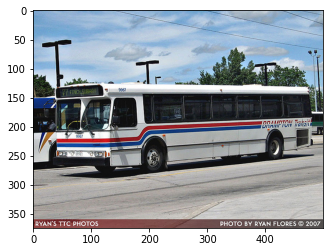

tensor([[-0.0960, -0.1480, -0.0048, -0.3665,  0.1394, -0.0731, -0.2105, -0.0596,
          0.0409, -0.1978,  0.0052, -0.0702,  0.0275, -0.1361,  0.0074,  0.0758,
         -0.0066, -0.3256, -0.0912,  0.1677]], grad_fn=<AddmmBackward0>) tensor([10])
tensor(2.9334, grad_fn=<NllLossBackward0>)
Batch: 2
['tvmonitor']
{'xmax': ['116'], 'xmin': ['1'], 'ymax': ['280'], 'ymin': ['128']}
1 128 116 280


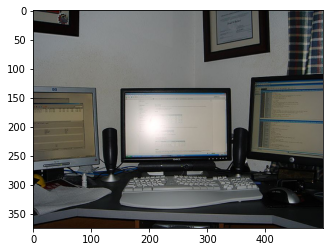

tensor([[ 0.3707, -0.0464,  0.2664,  0.3973, -0.1666,  0.0492,  0.1394,  0.1499,
          0.2359,  0.0550, -0.2975, -0.0920, -0.0692,  0.0659, -0.2298, -0.3272,
         -0.2747, -0.1060, -0.2650, -0.1097]], grad_fn=<AddmmBackward0>) tensor([0])
tensor(2.6360, grad_fn=<NllLossBackward0>)
Batch: 3
['aeroplane']
{'xmax': ['240'], 'xmin': ['146'], 'ymax': ['234'], 'ymin': ['214']}
146 214 240 234


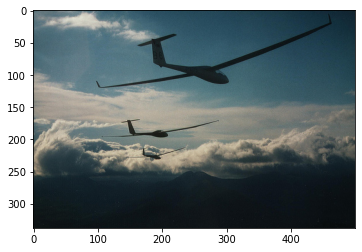

tensor([[ 0.1183, -0.2928,  0.0998, -0.2646, -0.0622,  0.3888,  0.3065, -0.1512,
          0.1047, -0.0417, -0.2742, -0.0602,  0.0332,  0.0564, -0.1310, -0.0543,
          0.1774,  0.1012,  0.2471,  0.1348]], grad_fn=<AddmmBackward0>) tensor([7])
tensor(3.1857, grad_fn=<NllLossBackward0>)
Batch: 4
['person']
{'xmax': ['216'], 'xmin': ['1'], 'ymax': ['290'], 'ymin': ['1']}
1 1 216 290


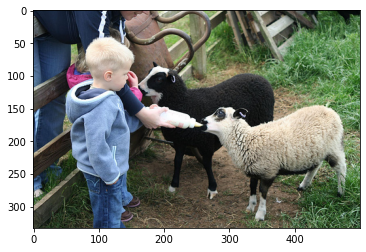

tensor([[-0.1173, -0.2360, -0.5655,  0.0579, -0.0967, -0.1235, -0.0559,  0.2801,
         -0.1620, -0.5223, -0.0581, -0.1843,  0.0137, -0.1145,  0.2004,  0.1287,
          0.1927,  0.1266, -0.1648,  0.1737]], grad_fn=<AddmmBackward0>) tensor([0])
tensor(3.0741, grad_fn=<NllLossBackward0>)
Batch: 5
['bottle']
{'xmin': ['82'], 'ymin': ['181'], 'xmax': ['106'], 'ymax': ['226']}
82 181 106 226


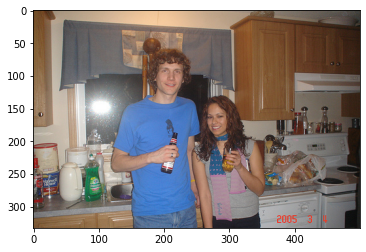

tensor([[ 0.2094,  0.3949, -0.1138, -0.8509,  0.2224,  0.0080,  0.4965,  0.0435,
         -0.2485, -0.1069, -0.0448, -0.0864, -0.4197, -0.4530,  0.6738,  0.0351,
          0.1442, -0.1500,  0.0877, -0.0703]], grad_fn=<AddmmBackward0>) tensor([14])
tensor(2.3642, grad_fn=<NllLossBackward0>)
Batch: 6
['motorbike']
{'xmin': ['405'], 'ymin': ['154'], 'xmax': ['471'], 'ymax': ['239']}
405 154 471 239


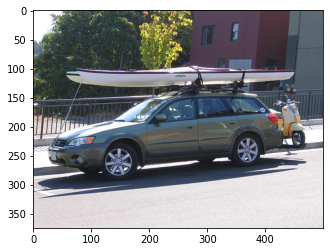

tensor([[-0.3998, -0.5070,  0.2614,  0.6745,  0.2524,  0.1650,  0.8787,  0.1985,
         -0.0943,  0.4185,  0.0311, -0.4551,  0.0416,  0.2164, -0.2648,  0.1950,
         -0.0056,  0.2092, -0.3367, -0.3410]], grad_fn=<AddmmBackward0>) tensor([12])
tensor(3.0782, grad_fn=<NllLossBackward0>)
Batch: 7
['person']
{'xmax': ['290'], 'xmin': ['126'], 'ymax': ['375'], 'ymin': ['31']}
126 31 290 375


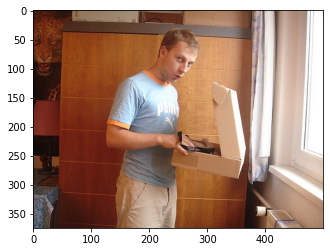

tensor([[-0.4730, -0.2896,  0.0791, -0.0180,  0.4471,  0.0321, -0.1658, -0.3787,
          0.1643, -0.2714, -0.1613,  0.4182,  0.7115,  0.6558,  0.1599,  0.2326,
         -0.5602, -0.6172, -0.1269, -0.0650]], grad_fn=<AddmmBackward0>) tensor([0])
tensor(3.5272, grad_fn=<NllLossBackward0>)
Batch: 8
['person']
{'xmin': ['2'], 'ymin': ['19'], 'xmax': ['132'], 'ymax': ['166']}
2 19 132 166


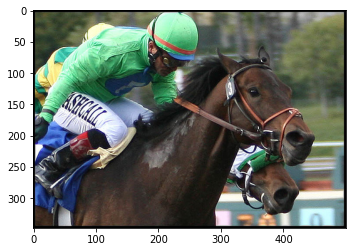

tensor([[-0.5071, -0.0956,  0.1018, -0.5273,  0.1673,  0.0127,  0.7542, -0.0621,
         -0.0655,  0.3115, -0.0239,  0.1111,  0.0161, -0.1118,  0.2387, -0.3742,
          0.3840,  0.2473, -0.5364,  0.4837]], grad_fn=<AddmmBackward0>) tensor([0])
tensor(3.5839, grad_fn=<NllLossBackward0>)
Batch: 9
['motorbike']
{'xmax': ['482'], 'xmin': ['13'], 'ymax': ['328'], 'ymin': ['32']}
13 32 482 328


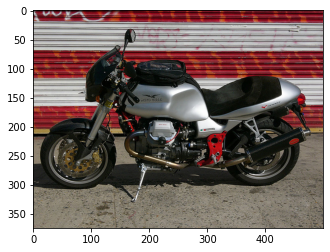

tensor([[-0.3931,  0.1085,  0.4757, -0.1681,  0.8301, -0.3468,  0.2612,  0.0716,
          0.4402, -0.3378, -0.0881,  0.2760,  0.1685, -0.0041,  0.1459, -0.2874,
         -0.4136, -0.1316, -0.0300, -0.1355]], grad_fn=<AddmmBackward0>) tensor([12])
tensor(2.9035, grad_fn=<NllLossBackward0>)
Batch: 10
['dog']
{'xmax': ['500'], 'xmin': ['1'], 'ymax': ['349'], 'ymin': ['1']}
1 1 500 349


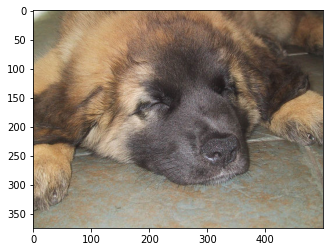

tensor([[-0.4542,  0.0572,  0.6148,  0.3015, -0.6118,  0.0605, -0.7076, -0.1072,
         -0.2676, -0.5348,  1.1441,  0.3902,  0.0045,  0.0539,  0.4412, -0.2348,
         -0.5562,  0.4299, -0.2850,  0.3873]], grad_fn=<AddmmBackward0>) tensor([4])
tensor(3.7297, grad_fn=<NllLossBackward0>)
Batch: 11
['tvmonitor']
{'xmax': ['92'], 'xmin': ['24'], 'ymax': ['327'], 'ymin': ['266']}
24 266 92 327


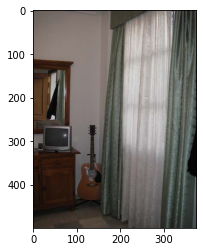

tensor([[-0.0805, -0.7451, -0.0874, -0.2263, -0.0404,  0.1569,  0.3963,  0.1167,
          0.1527, -0.0438,  0.5638, -0.6226, -0.2023,  0.5548,  0.6489,  0.7136,
          0.2375,  0.3757, -0.1292, -0.0314]], grad_fn=<AddmmBackward0>) tensor([0])
tensor(3.2312, grad_fn=<NllLossBackward0>)
Batch: 12
['cow']
{'xmin': ['233'], 'ymin': ['135'], 'xmax': ['359'], 'ymax': ['199']}
233 135 359 199


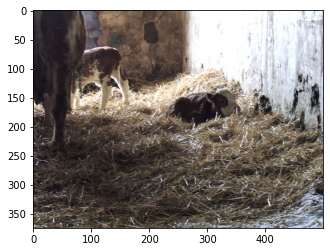

tensor([[-0.0700, -0.0196,  0.4012,  0.5396,  0.4399,  0.3685,  0.5732,  0.2267,
         -0.2873, -0.2506, -1.1320, -0.3165,  0.1591, -0.1505, -0.2921,  0.1463,
         -0.0818,  0.8339, -0.3791, -0.2655]], grad_fn=<AddmmBackward0>) tensor([3])
tensor(2.5668, grad_fn=<NllLossBackward0>)
Batch: 13
['person']
{'xmax': ['500'], 'xmin': ['4'], 'ymax': ['375'], 'ymin': ['100']}
4 100 500 375


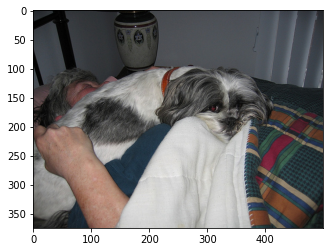

tensor([[ 0.5287,  0.4226,  0.9392, -0.2976,  0.5303, -0.4180, -0.1115,  0.6588,
         -0.0301,  0.7358, -0.3267,  0.3427, -0.5070,  0.9080, -0.1813, -0.4132,
          0.1619,  0.6429, -0.0066,  0.2508]], grad_fn=<AddmmBackward0>) tensor([0])
tensor(2.7608, grad_fn=<NllLossBackward0>)
Batch: 14
['car']
{'xmax': ['97'], 'xmin': ['1'], 'ymax': ['437'], 'ymin': ['341']}
1 341 97 437


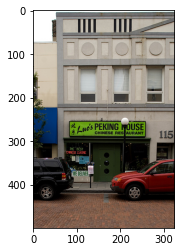

tensor([[ 0.6298,  0.1795,  0.4629,  0.2342,  0.9603, -0.2004,  0.0392, -0.1389,
          0.0010, -0.5061, -0.7219, -0.3715, -0.2070,  0.7843, -0.0244,  0.0192,
          0.2634, -0.2353, -0.9180,  0.3772]], grad_fn=<AddmmBackward0>) tensor([11])
tensor(3.5068, grad_fn=<NllLossBackward0>)
Batch: 15
['person']
{'xmin': ['441'], 'ymin': ['174'], 'xmax': ['450'], 'ymax': ['196']}
441 174 450 196


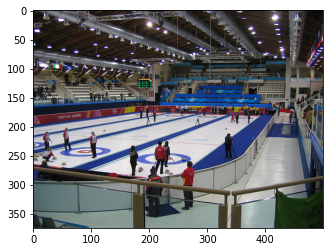

tensor([[-0.0891,  0.4465, -0.2521,  0.1553,  0.6535,  0.0264,  0.6148,  0.4915,
          0.2868, -0.7323,  0.5505,  0.1267, -0.3298, -0.8885,  0.4203, -0.8641,
         -0.4493, -0.3256,  0.5748, -0.4425]], grad_fn=<AddmmBackward0>) tensor([0])
tensor(3.1978, grad_fn=<NllLossBackward0>)
Batch: 16
['chair']
{'xmin': ['1'], 'ymin': ['255'], 'xmax': ['248'], 'ymax': ['500']}
1 255 248 500


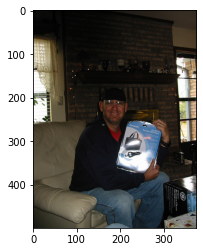

tensor([[ 0.1112, -0.2832, -0.4921, -0.3515, -0.5325,  0.1530,  0.2682, -0.7240,
          0.5812,  0.4014, -0.2624,  0.2240, -0.3232,  0.5561, -0.2082,  0.1379,
         -0.1209,  0.4677, -0.3622,  0.7018]], grad_fn=<AddmmBackward0>) tensor([15])
tensor(2.9375, grad_fn=<NllLossBackward0>)
Batch: 17
['chair']
{'xmax': ['155'], 'xmin': ['131'], 'ymax': ['146'], 'ymin': ['109']}
131 109 155 146


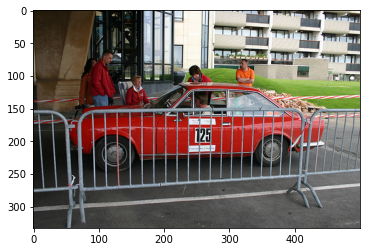

tensor([[ 0.1102, -0.3723,  0.1755,  0.0957, -0.1150, -0.6475, -0.0760,  0.0405,
          0.7869, -0.8781, -0.1158, -0.3856, -0.5949,  0.1939,  0.3877, -0.5608,
         -0.5321,  0.3972, -0.2645,  0.4721]], grad_fn=<AddmmBackward0>) tensor([15])
tensor(3.5525, grad_fn=<NllLossBackward0>)
Batch: 18
['cow']
{'xmax': ['318'], 'xmin': ['151'], 'ymax': ['296'], 'ymin': ['71']}
151 71 318 296


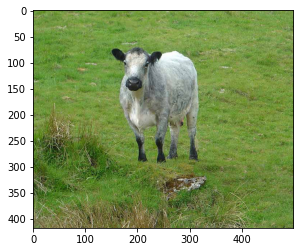

tensor([[ 0.3663, -0.0115,  0.0198,  0.3474, -0.1368,  0.0827, -0.2324,  0.1304,
         -0.4240, -0.3501,  0.0407,  0.4221, -0.8648,  0.5812,  0.3445,  0.1498,
          0.0731, -0.0094,  0.3905,  0.8394]], grad_fn=<AddmmBackward0>) tensor([3])
tensor(2.8021, grad_fn=<NllLossBackward0>)
Batch: 19
['chair']
{'xmin': ['136'], 'ymin': ['77'], 'xmax': ['436'], 'ymax': ['373']}
136 77 436 373


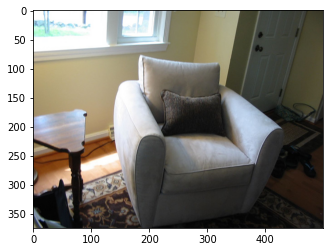

tensor([[ 0.6618,  0.3065, -0.0640,  1.1559, -0.2044,  1.2080, -0.3213,  0.6087,
         -0.0394,  0.3788,  0.2673,  0.1817,  0.9339,  1.0082, -0.2008,  0.0212,
         -0.6524,  0.2367, -0.1456,  0.1089]], grad_fn=<AddmmBackward0>) tensor([15])
tensor(3.3786, grad_fn=<NllLossBackward0>)
Batch: 20
['sheep']
{'xmin': ['267'], 'ymin': ['84'], 'xmax': ['390'], 'ymax': ['174']}
267 84 390 174


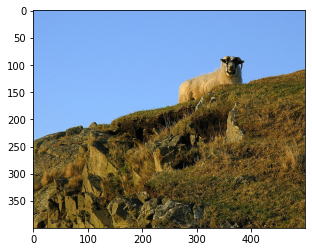

tensor([[ 0.2656, -0.0082,  0.0917,  0.3019,  0.2706, -0.1955, -0.1802,  0.5003,
         -1.1388, -0.1175, -0.7093, -0.5535,  0.2303, -0.5045,  0.4715,  0.2024,
          0.8885, -0.4391, -0.5494,  0.2242]], grad_fn=<AddmmBackward0>) tensor([6])
tensor(3.2357, grad_fn=<NllLossBackward0>)
Batch: 21
['car']
{'xmax': ['500'], 'xmin': ['475'], 'ymax': ['222'], 'ymin': ['190']}
475 190 500 222


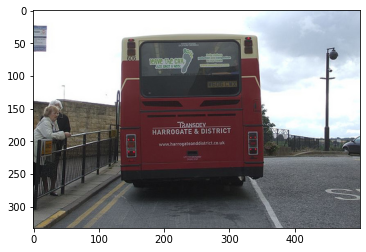

tensor([[ 0.9980,  0.1963, -0.3575,  0.3376,  0.2141,  0.1806, -0.3059,  0.4333,
         -0.1649,  0.1720, -0.6450,  0.0343, -0.2401,  0.2215,  0.9612, -0.7004,
          0.1894,  0.0305,  0.1779, -0.1331]], grad_fn=<AddmmBackward0>) tensor([11])
tensor(3.1353, grad_fn=<NllLossBackward0>)
Batch: 22
['boat']
{'xmin': ['97'], 'ymin': ['182'], 'xmax': ['310'], 'ymax': ['438']}
97 182 310 438


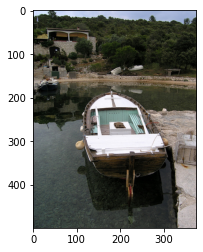

tensor([[-0.3404,  0.3517, -0.0849,  0.3780, -0.5964,  0.2915, -0.3932,  0.3160,
          0.4423,  0.2620, -0.3840,  0.5784,  0.4370, -0.6086, -0.9118,  0.8066,
         -0.0761,  0.1687, -0.3882, -0.1260]], grad_fn=<AddmmBackward0>) tensor([9])
tensor(2.8368, grad_fn=<NllLossBackward0>)
Batch: 23
['pottedplant']
{'xmin': ['102'], 'ymin': ['47'], 'xmax': ['176'], 'ymax': ['172']}
102 47 176 172


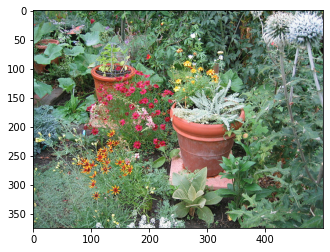

tensor([[ 0.1898, -0.2919, -0.2967,  0.5668, -0.4496,  0.7263,  0.4541,  0.0877,
          0.1548, -0.9166, -0.1802,  0.0728,  0.1860,  1.4214,  0.6464,  0.1403,
          0.2184,  0.8818, -0.0574, -0.9193]], grad_fn=<AddmmBackward0>) tensor([0])
tensor(3.0956, grad_fn=<NllLossBackward0>)
Batch: 24
['pottedplant']
{'xmin': ['1'], 'ymin': ['64'], 'xmax': ['69'], 'ymax': ['261']}
1 64 69 261


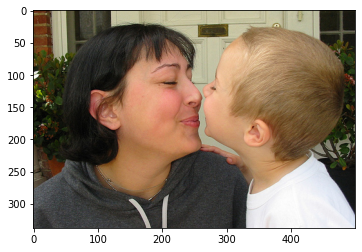

tensor([[ 0.6032,  0.7230, -0.0650, -0.4936, -0.3056,  0.3582, -0.1631,  0.1741,
         -0.4375,  0.5814,  0.2926,  0.1543,  0.7475,  0.1698, -1.3171,  0.0475,
         -0.2326,  0.7947,  0.1984,  1.1465]], grad_fn=<AddmmBackward0>) tensor([0])
tensor(2.6766, grad_fn=<NllLossBackward0>)


KeyboardInterrupt: ignored

In [37]:
import matplotlib.pyplot as plt
from PIL import Image

k=0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

epochs=25

model= model=DarkNetClassifier(BlockConv1, input_channels=3, num__kernels=1,  num_stride=1, num_classes=20)
#test_ConvClassifier()
model.to(device)

loss_functionn= torch.nn.CrossEntropyLoss().to(device)
opt=Adam(model.parameters(), lr=1e-4)


for epoch in range(epochs):
  ##for imgs, annotations in dataset_train.dataset:
  ##for i, (imgs, annotations) in enumerate(dataset_train):
  for batch in dataset_train:
    imgs, annotations = batch
    print("Batch: {}".format(k))
    #imgs = list(img.to(device) for img in imgs)
    #annotations = dict(annotations.items())

    image_copied=imgs
    image_copied = image_copied.squeeze(axis=0) #.to(device)

    imgs=transforms.Resize((224,224))(imgs)

        #X=X.squeeze(axis=0)
    x_min, y_min, x_max, y_max, obj_name, obj_coord = select_info(annotations)
    x_min, y_min, x_max, y_max=x_min[0], y_min[0], x_max[0], y_max[0]
    print(obj_name)
    print(obj_coord)
    print(x_min, y_min, x_max, y_max)
    
    Y=class_names.get(obj_name[0])
    if Y is None:
      Y = 0
    Y=torch.tensor(Y, dtype=torch.long).reshape(-1,1)
    Y=Y.squeeze(0)

    ##Y=F.one_hot(Y, num_classes=20)
    #Y=annotations

    ##Crop images
    ##crop_images(image_copied, x_min, y_min, x_max, y_max)

    image_copied_=transforms.ToPILImage()(image_copied)
    plt.imshow(image_copied_)
    plt.show()
    
    Y_pred= model(imgs)
    ##aux=create_array(Y_pred)
    ##print("Label: {}".format(torch.argmax(aux)))
    ##print("Prediction: {}".format(torch.argmax(Y)))

    ##print(aux)
    ##print(Y.squeeze(0).squeeze(0))
    #Y_pred=torch.argmax(Y_pred)
    #loss= loss_functionn(aux,Y.squeeze(0).squeeze(0))

    print(Y_pred,Y)

    loss= loss_functionn(Y_pred,Y)
    print(loss)
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    k+=1
    
    del annotations
    del Y_pred
    del imgs
  print("Epoch:{}, loss:{}".format(epoch, loss.item()))

In [ ]:
no_of_layers=0
conv_layers=[]
 
model_children=list(model.children())
 
for child in model_children:
  if type(child)==nn.Conv2d:
    no_of_layers+=1
    conv_layers.append(child)
  elif type(child)==nn.Sequential:
    for layer in child.children():
      if type(layer)==nn.Conv2d:
        no_of_layers+=1
        conv_layers.append(layer)
print(no_of_layers)

In [ ]:
results = [conv_layers[0](imgs)]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results

In [ ]:
import cv2

for num_layer in range(len(outputs)):
    plt.figure(figsize=(50, 10))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print("Layer ",num_layer+1)
    for i, filter in enumerate(layer_viz):
        if i == 16: 
            break
        plt.subplot(2, 8, i + 1)
        image = cv2.cvtColor(abs(filter.cpu().numpy()), cv2.COLOR_BGR2RGB)
        plt.imshow(image, cmap='gray')
        plt.axis("off")
    plt.show()
    plt.close()

In [ ]:
for i in range(10):
  image_copied=transforms.ToPILImage()(layer_viz[i])
  plt.imshow(image_copied)
  plt.show()
